# The determination of colors

Here I presented my approach to determining which colors match with which skin tone. <br>
The whole principle is based on a fashion idea that based on person skin tone and undertone there is a group of the colors that makes a person look more rested, skin more even. <br>
My first step was researching is there any scientific background in all this or this is just another "snake oil." <br>
Well, it turned out there are some reasonable sets of the facts behind the whole idea. And surprisingly the whole idea uses imperfection of the human eye, the same imperfection that makes us see the same color as different when that color is surrounded by some other colors. This is famous optical illusion and I explained it in details in my blog:  <a href="https://villepique.wordpress.com/2016/04/04/fashion-colors/"> Fashion Colors </a>


So, let us do an analysis. <br> Start with importing of the pandas and datasets. 

In [1]:
import pandas as pd

Datasets consist from the cluster centroids I explained in the blog post linked above, and the mean values for the skin tone of the person which I got processing images with Mahotas package.

In [2]:
co = pd.read_csv('Centroids2.csv')
matching=pd.read_csv('CentroidsC.csv')
skin=pd.read_csv('Skin.csv')

Checking the datasets. They should be fine, data are initially saved as CSV files, in a database of star design. 


In [3]:
co.head()

,Unnamed: 0,R,G,B,colorID
0,4,0,58,69,1
1,16,0,0,255,2
2,19,0,255,255,3
3,5,7,156,173,4
4,21,14,135,110,5


In [4]:
matching.head()

,colorID,A1,A2,A3,A4,A5,B,C,D,E,F,G
0,1,0,0,1,0,0,0,0,0,1,0,1
1,2,0,0,1,0,1,0,1,1,0,1,1
2,3,1,0,0,0,0,0,0,0,1,0,0
3,4,1,1,0,1,1,0,1,0,0,1,0
4,5,1,0,0,0,0,1,1,0,1,0,0


In [5]:
skin.head()

,Person ID,skinR,skinG,skinB
0,A1,126.55,101.434,94.139
1,A2,152.80,111.340,76.690
2,A3,140.15,118.310,127.480
3,A4,159.43,114.950,103.450
4,A5,127.13,95.740,90.320


The first step is to check my assumption that human skin has linear dependance between red and blue color channel. I formed this hypothesis after I read about the so-called 'blue people of Appalachian region.' <br>
Those people have distinctive blue hue due to lack of certain blood enzyme that is crucial in enabling hemoglobin bond to the oxygen. Basically, an amount of that enzyme determines how much blue a human will have in their skin hue. 

In [6]:
import scipy
from matplotlib import pyplot as plt
%pylab inline

/Users/Lexa/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Populating the interactive namespace from numpy and matplotlib


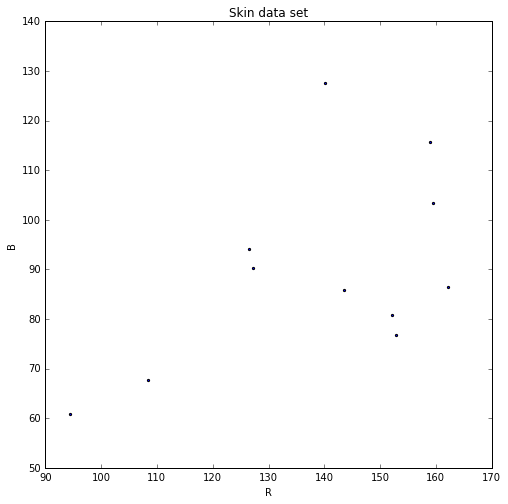

In [7]:
plt.figure(figsize=(8, 8), dpi=100)
skin_scatter = plt.scatter(skin['skinR'], skin['skinB'], alpha=1, s=5)
plt.title('Skin data set')
plt.xlabel('R')
plt.ylabel('B')
plt.show()

In [8]:
def basic_linear_regression(x, y):   
    length = len(x)
    sum_x = sum(x)
    sum_y = sum(y)
    # Σx^2, and Σxy respectively.
    sum_x_squared = sum(map(lambda a: a * a, x))
    sum_of_products = sum([x[i] * y[i] for i in range(length)])  
    a = (sum_of_products - (sum_x * sum_y) / length) / (sum_x_squared - ((sum_x ** 2) / length))
    b = (sum_y - a * sum_x) / length
    return a, b

In [9]:
import seaborn as sns

/Users/Lexa/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [10]:
xh = skin["skinR"].values
x =xh/1.
yh = skin["skinB"].values
y = yh/1.
regression = basic_linear_regression(x,y)
print  regression

(0.47416179700697042, 24.161316401722182)


/Users/Lexa/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


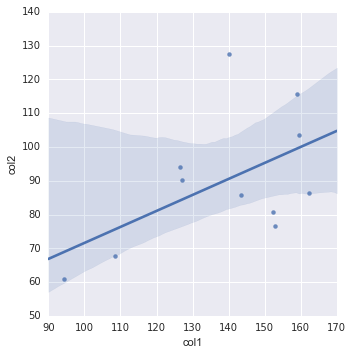

In [11]:
d = {'col1': x, 'col2': y}
xx = pd.DataFrame(data=d)
sns.lmplot('col1','col2',xx)

As I expected, there is a linear dependence between Red and Blue channel of the skin, regardless of the race. This is actually supported by the medical findings of the amount of the enzyme which regulates hemoglobin's ability to capture oxygen. 

# Developing an Algorithm

Just for the heck of it, I decided not to use SQL commands but instead use the pure python. <br>
As you can see, a length of the code openly advocates for combining SQL queries into python code. 

In [12]:
def makeSubframe(skinFrame, matchingFrame,colName,colInd):
    series=matchingFrame[colName]
    R=skinFrame['skinR'].values
    G=skinFrame['skinG'].values
    B=skinFrame['skinB'].values
    series3=series*0
    testR=series3+R[colInd]
    testG=series3+G[colInd]
    testB=series3+B[colInd]
    series2=[testR,testG,testB]
    test=pd.concat(series2,axis=1)
    test.columns=['R','G','B']
    test['colorID']=matching['colorID']
    test['good']=series
    
    return test

In [13]:
people=list(matching.columns.values)
people.pop(0)
testPeople=[people[-1]]
people.pop(-1)
#testPeople

'G'

In [14]:
def makeTable (colNames, skinFrame, matchingFrame):
    num=0
    for l in colNames:
        if num == 0:
            test=makeSubframe(skinFrame,matchingFrame, l, num)
        else:
            test2=makeSubframe(skinFrame,matchingFrame, l, num)
            test=pd.concat([test,test2], ignore_index=True)
        num+=1
    return test

In [15]:
result=makeTable(people, skin, matching)
result.head()

,R,G,B,colorID,good
0,126.55,101.434,94.139,1,0
1,126.55,101.434,94.139,2,0
2,126.55,101.434,94.139,3,1
3,126.55,101.434,94.139,4,1
4,126.55,101.434,94.139,5,1


In [16]:
df=pd.merge(result, co, left_on='colorID', right_on='colorID')
df.columns=['skinR','skinG','skinB', 'colorID', 'good', 'colorCluster', 'R','G','B']
df.head()

,skinR,skinG,skinB,colorID,good,colorCluster,R,G,B
0,126.55,101.434,94.139,1,0,4,0,58,69
1,152.80,111.340,76.690,1,0,4,0,58,69
2,140.15,118.310,127.480,1,1,4,0,58,69
3,159.43,114.950,103.450,1,0,4,0,58,69
4,127.13,95.740,90.320,1,0,4,0,58,69


Now when I have a table, the next step is to see is there any simple correlation between color channels of the skin and color channels of the test colors. 

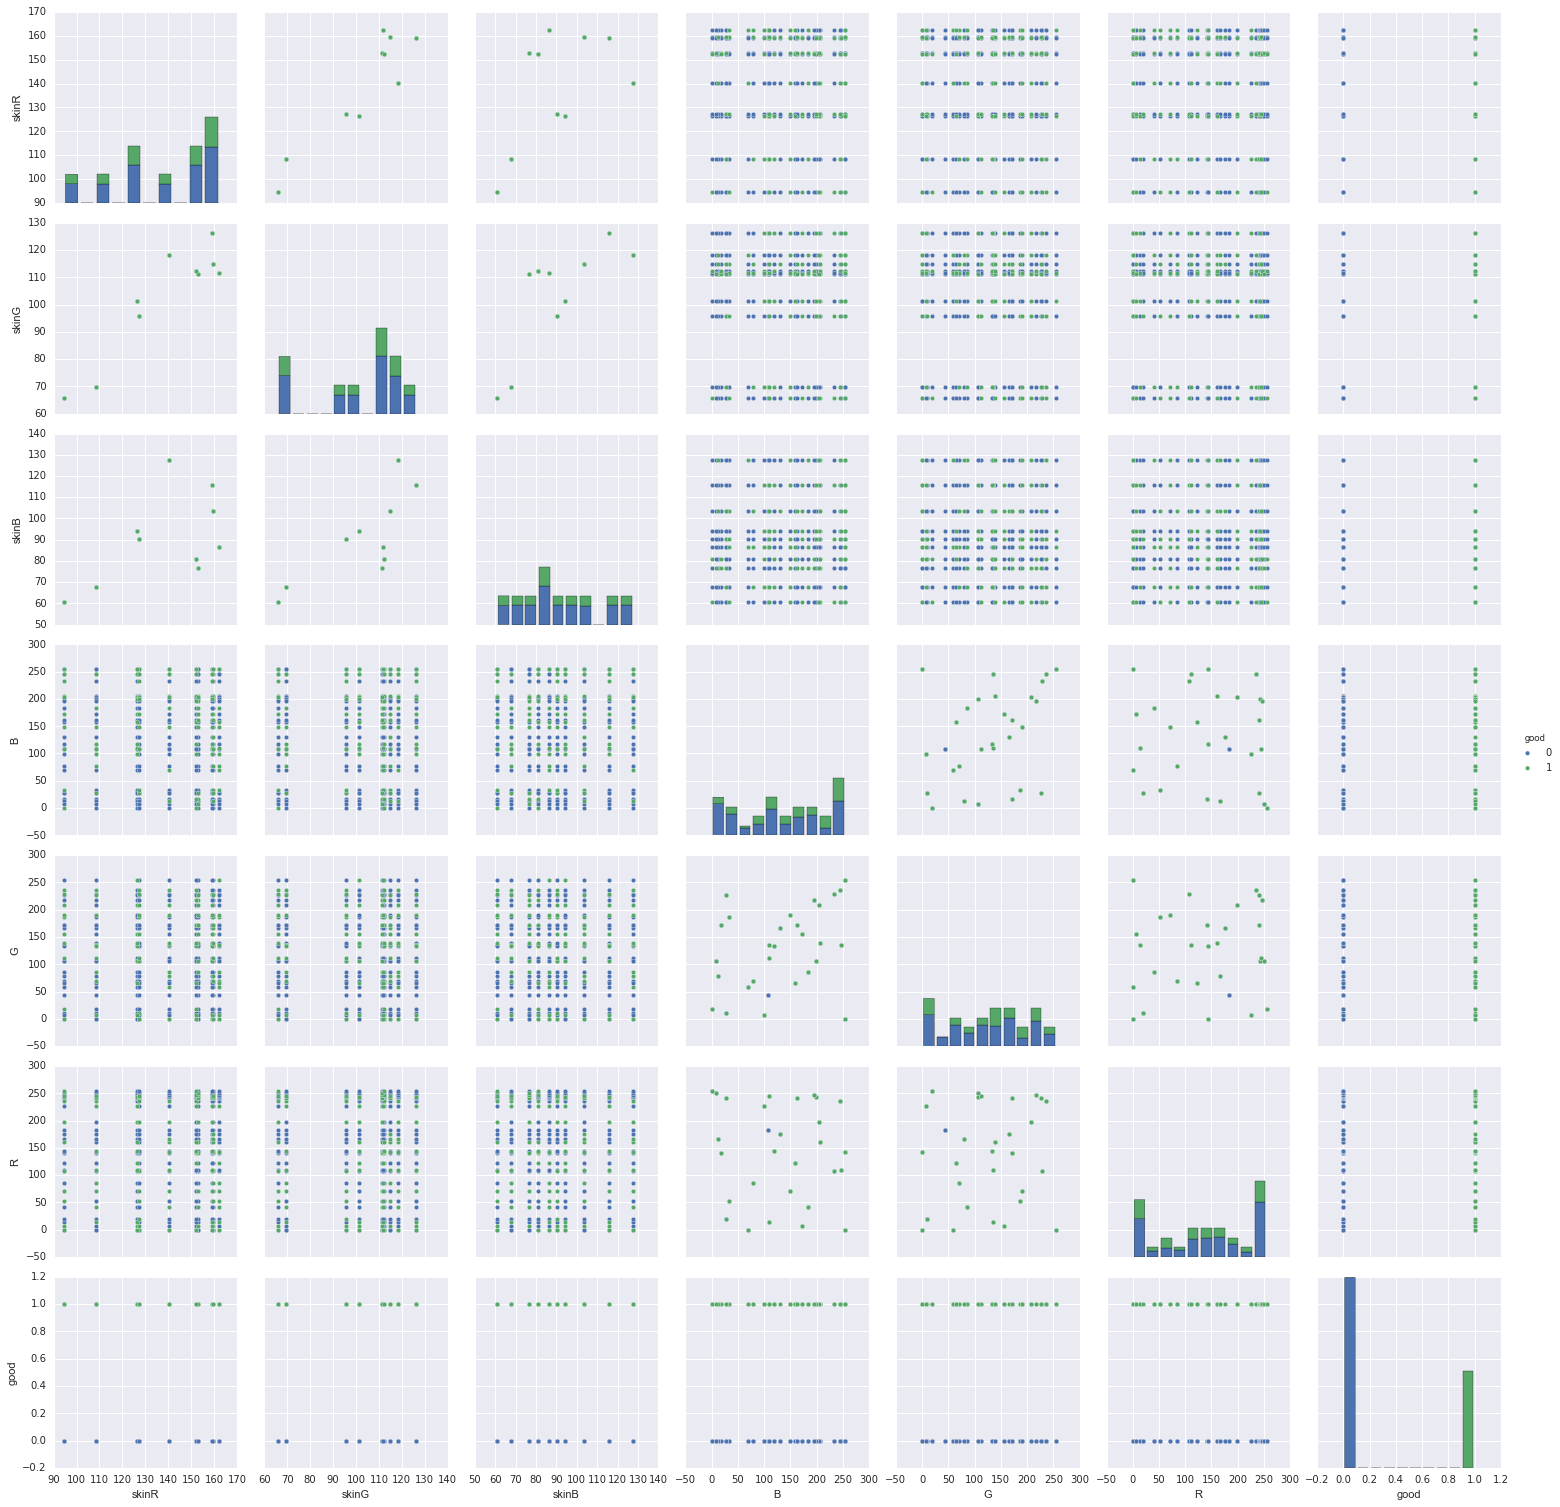

In [17]:
sns.set_style('darkgrid')
sns.pairplot(df[['skinR','skinG','skinB', 'B', 'G','R', 'good']],hue='good')

There is no apparent linear dependency between the color channels. The linear dependencies you see in the overview are between channels of the same group of colors. I need dependency between different groups of colors, between skin colors and my cluster centers.<br>
Above, I explained why skin has a linear dependency. For the test colors, I made them linear. My first approach was to pick up already developed method of the color determination that already exists in fashion. But that method formed categoric variable with 17th different categories. My tiny data set could not possibly give a result. I have fewer humans in my dataset than existing categories. So, I made a continuous variable out of fabric colors. Existing colors were analyzed with K-means, and I used 30 cluster centers as representative of the testing colors. <br>
Now I have to see is it possible to make something work with Random Forest. 

In [18]:
from sklearn.ensemble import RandomForestClassifier
#string col. is problem so we need to convert it 
from sklearn.preprocessing import LabelEncoder #good for cleaning data or use OneHotEncoder
from sklearn.cross_validation import KFold

In [19]:
clf =RandomForestClassifier()

# Setting test and train data set
Unfortunately, I cannot just take random points and separate dataset to test and train set. See, although I have 30 data points per face, it is still one face, so in essence that is just one data point. Instead, I took, randomly a  face with all 30 data points as a test, and left other 10 faces in train data set. <br>
Below is making of test data set.

In [20]:
test=makeSubframe(skin,matching, testPeople[0], -1)
test.head()

,R,G,B,colorID,good
0,143.52,102.5,85.79,1,1
1,143.52,102.5,85.79,2,1
2,143.52,102.5,85.79,3,0
3,143.52,102.5,85.79,4,0
4,143.52,102.5,85.79,5,0


In [21]:
df2=pd.merge(test, co, left_on='colorID', right_on='colorID')
df2.columns=['skinR','skinG','skinB', 'colorID', 'good', 'colorCluster', 'R','G','B']
df2.head()

,skinR,skinG,skinB,colorID,good,colorCluster,R,G,B
0,143.52,102.5,85.79,1,1,4,0,58,69
1,143.52,102.5,85.79,2,1,16,0,0,255
2,143.52,102.5,85.79,3,0,19,0,255,255
3,143.52,102.5,85.79,4,0,5,7,156,173
4,143.52,102.5,85.79,5,0,21,14,135,110


In [22]:
Y_train=df.good
X_train =df[[c for c in df.columns if c not in ( 'good', 'colorID', 'colorCluster')]]
X_test = df2[[c for c in df2.columns if c not in ( 'good', 'colorID', 'colorCluster')]]
Y_test = df2.good

In [23]:
clf.fit(X_train, Y_train)
print clf.score(X_test,Y_test)

0.666666666667


Quite a decent score, meaning that Random Forest approach works, and although results are not as good as I would like them, they are good enough considering that the whole analysis was done with just 10 different faces. <br>
I expect that accuracy of the method will improve with the adding more data points.<br>
<br>
Now a just another test with the previously unused data. I do have to make sure there is no overfitting of the model. 

Here I entered values for another person, where agreement with colors was done by a human. After all, the algorithm needs to learn how to describe color illusion typical for a human eye.<br>
The list named pom contains values for color matching. The list named pom2 contains average skin values of the person. 

In [24]:
pom=[1,0,1,1,0,1,1,1,1,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
pom2=[161.8,128.43,127.38]

Next, I manually change values in existing test matrix, so that skin value match my test subject.

In [25]:
X_doubleTest=X_test
X_doubleTest.skinR=X_test.skinR*0.+161.8
X_doubleTest.skinG=X_test.skinG*0.+128.43
X_doubleTest.skinB=X_test.skinB*0.+127.38

/Users/Lexa/anaconda/lib/python2.7/site-packages/pandas/core/generic.py:2387: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [26]:
X_doubleTest.head()

,skinR,skinG,skinB,R,G,B
0,161.8,128.43,127.38,0,58,69
1,161.8,128.43,127.38,0,0,255
2,161.8,128.43,127.38,0,255,255
3,161.8,128.43,127.38,7,156,173
4,161.8,128.43,127.38,14,135,110


And, we run prediction. 

In [27]:
Y_doubleTest=clf.predict(X_doubleTest)

Let us see a percentage of agreement between predicted values and human-determined values.

In [28]:
pom3=Y_doubleTest-pom

In [29]:
pom4=[pom3 == 0]

In [30]:
print(sum(pom4)/30.)

0.7


So, even this second test shows that model has potential. <br>
The biggest fault of this algorithm is a small data set. I have in total 12 people. 10 are used for the training set, 1 for the testing set and 1 for the prediction set. <br>
My belief is that a larger data set this model would increase the accuracy. 